## Import Packages

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

## Load Training Dataset

In [3]:
# Function to prepare the data
def prepare_data(data_dir):
    dataframes = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(data_dir, filename))
            # Drop the "cycle index" column
            df = df.drop(columns=['Cycle_Index'], errors='ignore')
            dataframes.append(df)
    
    # Drop highly correlated features
    combined_data = pd.concat(dataframes, axis=0, ignore_index=True)
    corr_matrix = combined_data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    
    for i in range(len(dataframes)):
        dataframes[i] = dataframes[i].drop(columns=to_drop)
    
    return dataframes, to_drop

In [4]:
# Load and prepare the data
data_dir = 'E:\\Features_Dataset'
dataframes, to_drop = prepare_data(data_dir)

## Split into Training and Validation Sets

In [5]:
# Split the dataframes for training and validation
train_dataframes = dataframes[:80]
val_dataframes = dataframes[80:]

In [6]:
# Standardize and transform the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [7]:
X_train = np.concatenate([scaler_X.fit_transform(df.drop(columns=['Nominal_Capacity'])) for df in train_dataframes])
y_train = np.concatenate([scaler_y.fit_transform(df['Nominal_Capacity'].values.reshape(-1, 1)) for df in train_dataframes]).ravel()
X_val = np.concatenate([scaler_X.transform(df.drop(columns=['Nominal_Capacity'])) for df in val_dataframes])
y_val = np.concatenate([scaler_y.transform(df['Nominal_Capacity'].values.reshape(-1, 1)) for df in val_dataframes]).ravel()

## Train the Model

In [8]:
# Train the XGBoost model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

[0]	validation_0-rmse:0.75092
[1]	validation_0-rmse:0.68630
[2]	validation_0-rmse:0.63050
[3]	validation_0-rmse:0.56936
[4]	validation_0-rmse:0.52125
[5]	validation_0-rmse:0.47785
[6]	validation_0-rmse:0.43862
[7]	validation_0-rmse:0.40012


C:\Users\Rishi\.conda\envs\tf-new\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:0.36899
[9]	validation_0-rmse:0.34260
[10]	validation_0-rmse:0.31734
[11]	validation_0-rmse:0.29302
[12]	validation_0-rmse:0.28049
[13]	validation_0-rmse:0.26388
[14]	validation_0-rmse:0.25238
[15]	validation_0-rmse:0.24530
[16]	validation_0-rmse:0.23647
[17]	validation_0-rmse:0.23218
[18]	validation_0-rmse:0.22679
[19]	validation_0-rmse:0.22308
[20]	validation_0-rmse:0.21820
[21]	validation_0-rmse:0.21585
[22]	validation_0-rmse:0.21343
[23]	validation_0-rmse:0.21065
[24]	validation_0-rmse:0.21209
[25]	validation_0-rmse:0.21283
[26]	validation_0-rmse:0.21167
[27]	validation_0-rmse:0.23068
[28]	validation_0-rmse:0.25167
[29]	validation_0-rmse:0.25293
[30]	validation_0-rmse:0.25566
[31]	validation_0-rmse:0.25633
[32]	validation_0-rmse:0.26194
[33]	validation_0-rmse:0.26916


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# Function to prepare testing data
def prepare_test_data(test_data_dir, scaler_X, time_steps, to_drop):
    test_dataframes = []
    for filename in os.listdir(test_data_dir):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(test_data_dir, filename))
            # Drop the "cycle index" column
            df = df.drop(columns=['Cycle_Index'], errors='ignore')
            df = df.drop(columns=to_drop)
            test_dataframes.append(df)
    test_data = pd.concat(test_dataframes, axis=0, ignore_index=True)
    X_test = test_data.drop(columns=['Nominal_Capacity'])
    y_test = test_data['Nominal_Capacity']
    X_test_scaled = scaler_X.transform(X_test)
    return X_test_scaled, y_test.values

In [10]:
# Load and prepare the testing data
test_data_dir = 'E:\\Testing Data'
X_test, y_test = prepare_test_data(test_data_dir, scaler_X, 0, to_drop)

In [11]:
# Evaluate the model on testing data
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))
y_test_descaled = y_test.reshape(-1, 1)

In [12]:
mae = mean_absolute_error(y_test_descaled, predictions)
rmse = np.sqrt(mean_squared_error(y_test_descaled, predictions))
mape = np.mean(np.abs((y_test_descaled - predictions) / y_test_descaled)) * 100
r2 = r2_score(y_test_descaled, predictions)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}%')
print(f'R-squared: {r2:.4f}')

MAE: 0.0092
RMSE: 0.0139
MAPE: 0.9083%
R-squared: 0.8892


Plot saved to C:\Users\Rishi\Documents\Images\XG_Pred_All_Data


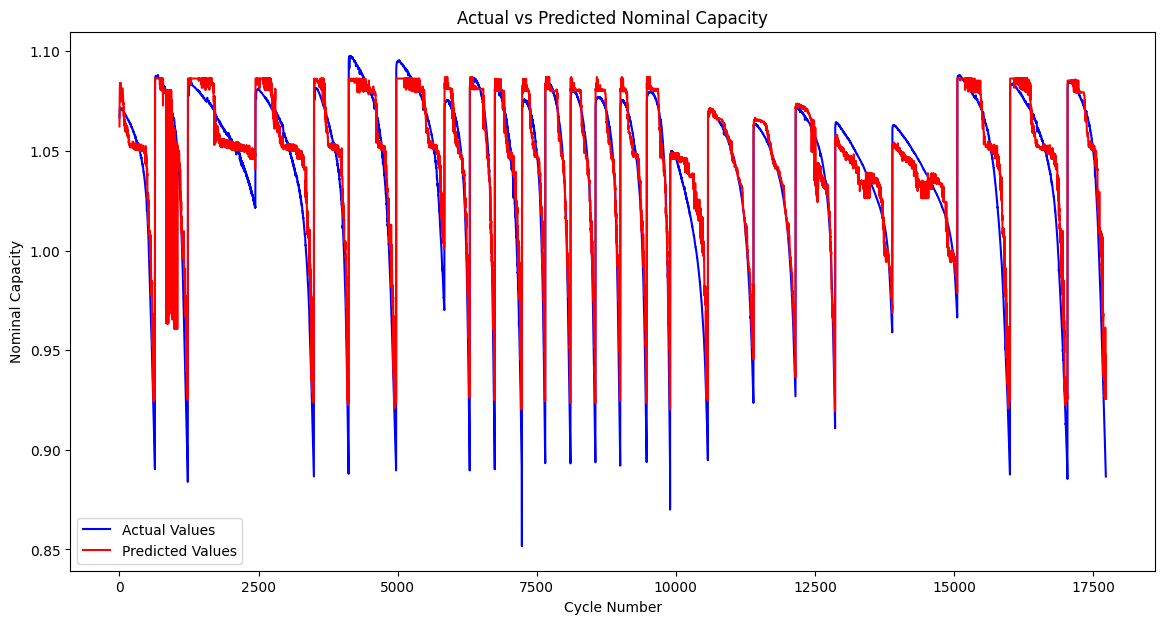

In [13]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_descaled, label='Actual Values', color='b')
plt.plot(predictions, label='Predicted Values', color='r')
plt.title('Actual vs Predicted Nominal Capacity')
plt.xlabel('Cycle Number')
plt.ylabel('Nominal Capacity')
plt.legend()

# Save the plot if save_path is provided
save_path = 'C:\\Users\\Rishi\\Documents\\Images\\XG_Pred_All_Data'

if save_path:
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")

plt.show()

In [14]:
# Load a specific testing dataset
specific_test_df = pd.read_csv('E:\\Testing Data\\Battery_115_Features.csv')

In [15]:
# Drop the "cycle index" column and highly correlated features
specific_test_df = specific_test_df.drop(columns=['Cycle_Index'], errors='ignore')
specific_test_df = specific_test_df.drop(columns=to_drop)

In [16]:
# Separate features and target
X_specific_test = specific_test_df.drop(columns=['Nominal_Capacity'])
y_specific_test = specific_test_df['Nominal_Capacity']

In [17]:
# Scale the features
X_specific_test_scaled = scaler_X.transform(X_specific_test)

In [18]:
# Make predictions
predictions_specific_scaled = model.predict(X_specific_test_scaled)
predictions_specific = scaler_y.inverse_transform(predictions_specific_scaled.reshape(-1, 1))
y_specific_test_descaled = y_specific_test.values.reshape(-1, 1)

Plot saved to C:\Users\Rishi\Documents\Images\XG_Pred_Single_Data


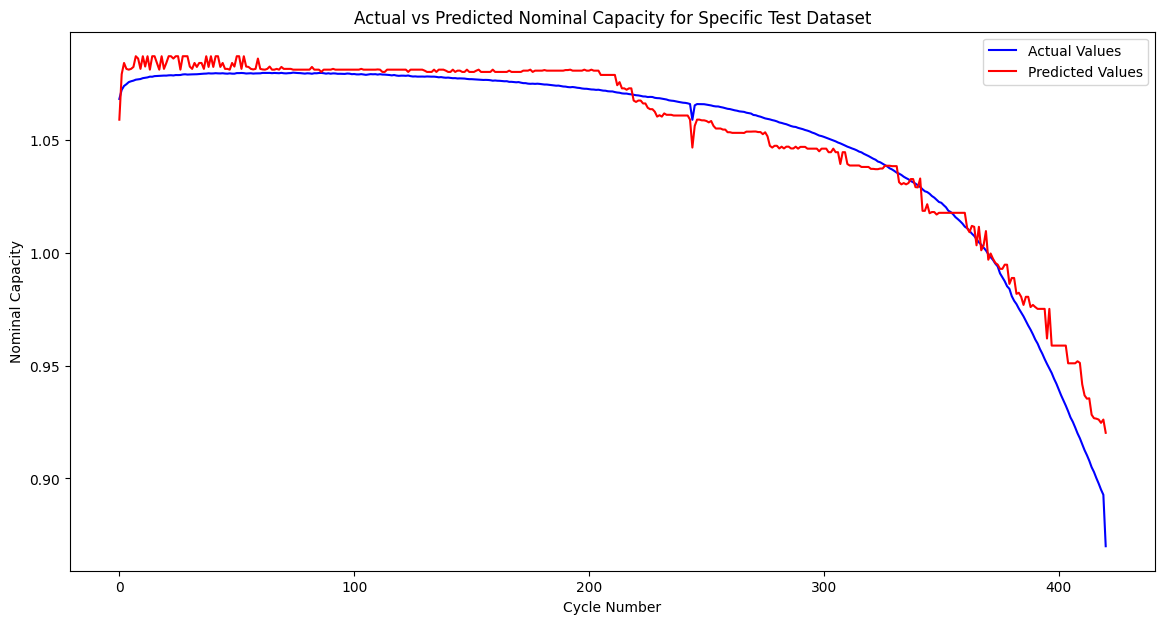

In [19]:
# Plot the actual vs predicted values for the specific test dataset
plt.figure(figsize=(14, 7))
plt.plot(y_specific_test_descaled, label='Actual Values', color='b')
plt.plot(predictions_specific, label='Predicted Values', color='r')
plt.title('Actual vs Predicted Nominal Capacity for Specific Test Dataset')
plt.xlabel('Cycle Number')
plt.ylabel('Nominal Capacity')
plt.legend()

# Save the plot if save_path is provided
save_path = 'C:\\Users\\Rishi\\Documents\\Images\\XG_Pred_Single_Data'

if save_path:
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")

plt.show()

In [20]:
mae = mean_absolute_error(y_specific_test_descaled, predictions_specific)
rmse = np.sqrt(mean_squared_error(y_specific_test_descaled, predictions_specific))
mape = np.mean(np.abs((y_specific_test_descaled - predictions_specific) / y_specific_test_descaled)) * 100
r2 = r2_score(y_specific_test_descaled, predictions_specific)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}%')
print(f'R-squared: {r2:.4f}')

MAE: 0.0064
RMSE: 0.0088
MAPE: 0.6324%
R-squared: 0.9591
